# Brem and Eta comparisons

This notebook is for comparing the hit rates and distributions in the Brem and Eta files across two different masses (Brem: 0.03 and 0.47 eV, Eta: 0.01 and 0.54 eV) in 1 dimension

In [1]:
import uproot4
import uproot
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from coffea import hist

# defining file I/O 

In [2]:
Brem003 = "sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
truth003 = uproot.open(Brem003)["Truth"]

Brem047 = "sim_eval_Brem_0.470915_z500_600_eps_-6.root"
truth047 = uproot.open(Brem047)["Truth"]

Eta001 = "sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
truth001 = uproot.open(Eta001)["Truth"]

Eta054 = "sim_eval_Eta_0.540000_z500_600_eps_-6.root"
truth054 = uproot.open(Eta054)["Truth"]

# plot function

In [3]:
Brem003

'sim_eval_Brem_0.033428_z500_600_eps_-5.2.root'

In [4]:
def plot1D(root1, root2, name1, name2, zs=False):
    '''
    takes two ROOT files and their names and plots the detector occupancies for all stations
    the two ROOT files should be the same process (Brem/Eta) but diff masses
    zs enables plotting the detector z values for debugging
    '''
    # getting masses and process for plot labels
    process = name1.split("_")[2]
    mass1 = name1.split("_")[3]
    mass2 = name2.split("_")[3]
    masses = [mass1,mass2]
    
    (root1.array("hit_detID").flatten() >= 1).any()
    masks1 = {}
    (root2.array("hit_detID").flatten() >= 1).any()
    masks2 = {}
    
    # mask by hit detID
    detID1 = root1.array("hit_detID").flatten()
    detID2 = root2.array("hit_detID").flatten()
    
    # mask by z pos of detector
    truthz1 = root1.array("hit_truthz").flatten()
    truthz2 = root2.array("hit_truthz").flatten()
    
    # hodos
    masks1["h1BT"] = np.logical_and(detID1 >= 31, detID1 <= 32)
    masks2["h1BT"] = np.logical_and(detID2 >= 31, detID2 <= 32)
    masks1["h1LR"] = np.logical_and(detID1 >= 33, detID1 <= 34)
    masks2["h1LR"] = np.logical_and(detID2 >= 33, detID2 <= 34)
    masks1["h2LR"] = np.logical_and(detID1 >= 35, detID1 <= 36)
    masks2["h2LR"] = np.logical_and(detID2 >= 35, detID2 <= 36)
    masks1["h2BT"] = np.logical_and(detID1 >= 37, detID1 <= 38)
    masks2["h2BT"] = np.logical_and(detID2 >= 37, detID2 <= 38)
    masks1["h4Y1LR"] = np.logical_and(detID1 >= 41, detID1 <= 42)
    masks2["h4Y1LR"] = np.logical_and(detID2 >= 41, detID2 <= 42)
    masks1["h4Y2LR"] = np.logical_and(detID1 >= 43, detID1 <= 44)
    masks2["h4Y2LR"] = np.logical_and(detID2 >= 43, detID2 <= 44)
    masks1["h4BT"] = np.logical_and(detID1 >= 45, detID1 <= 46)
    masks2["h4BT"] = np.logical_and(detID2 >= 45, detID2 <= 46)
    
    # stations
    masks1["st1"] = np.logical_and(truthz1 > 500, truthz1 < 1000)
    masks2["st1"] = np.logical_and(truthz2 > 500, truthz2 < 1000)
    masks1["st2"] = np.logical_and(truthz1 > 1200, truthz1 < 1600)
    masks2["st2"] = np.logical_and(truthz2 > 1200, truthz2 < 1600)
    masks1["st4"] = truthz1 > 2000
    masks2["st4"] = truthz2 > 2000 
    
    # det pairs (common for both Brem/Eta and between both masses)
    det_st = [('h1BT', 'st1'),
              ('h1LR', 'st1'),
              ('h2LR', 'st2'),
              ('h2BT', 'st2'),
              ('h4Y1LR', 'st4'),
              ('h4Y2LR', 'st4'),
              ('h4BT', 'st4')]
    
    # geometry, can safely ignore z pos for now
    vs = [("xy","hit_truthy:hit_truthx","x [cm];y [cm]"),
          ("z","hit_truthz","z [cm]"),]
    
    # now implement all the masks, plotting each of the variables in det_pairs
    for det, st in det_st:
        for vshort, var, vtitle in vs:
            title = "Hits per Event in {} ({})".format(det,process)
            savename = vshort+"_"+det+"_"+st+"_"+process+"_hitsperevent"
            mask1 = np.logical_and(masks1[det],masks1[st])
            mask2 = np.logical_and(masks2[det],masks2[st])
            nevents = 10000    # simply averaging by divding by number of events
            
            plt.clf()
            ivars1 = [root1.array(v).flatten() for v in var.split(":")]
            ivars2 = [root2.array(v).flatten() for v in var.split(":")]
            ilabs = vtitle.split(';')
            
            if (zs == True):
                fig = plt.figure()
                ax = fig.add_subplot(111)
                # stacking the data to overlay on one hist
                x = [ivars1[0][mask1], ivars2[0][mask2]]
                # ivars[1] is y-vals, ivars[0] is x-vals
                counts, xedges, im = ax.hist(x, histtype='step',label=masses)
                ax.set_ylabel('Hits/Event')
                if (det[-1]=='T'):
                    ax.set_xlabel(ilabs[0]) # ilabs[1] is y-vals, ilabs[0] is x-vals
                else:
                    ax.set_xlabel(ilabs[1])
                ax.set_title(title)
                ax.legend(prop={'size': 10})
                #plt.savefig(savename)
                plt.show()
            else:
                if (len(ivars1)>1) and (len(ivars2)>1):
                    fig = plt.figure();
                    ax = fig.add_subplot(111);
                    # stacking the data
                    if (det[-1]=='T'):
                        x = [ivars1[0][mask1], ivars2[0][mask2]]
                    else:
                        x = [ivars1[1][mask1], ivars2[1][mask2]]
                    # ivars[1] is y-vals, ivars[0] is x-vals
                    counts, xedges, im = ax.hist(x, histtype='step',label=masses);
                    ax.set_ylabel('Hits/Event');
                    if (det[-1]=='T'):
                        ax.set_xlabel(ilabs[0]); # ilabs[1] is y-vals, ilabs[0] is x-vals
                    else:
                        ax.set_xlabel(ilabs[1]);
                    ax.set_title(title);
                    ax.legend(prop={'size': 10});
                    #plt.savefig(savename)
                    plt.show();


In [5]:
def plot2D(root):
    '''
    plots the hit distribution in the various detectors
    given root file name in working directory
    '''
    mass = root.split("_")[3]
    process = root.split("_")[2]
    truth = uproot.open(root)["Truth"]
    
    (truth.array("hit_detID").flatten() >= 1).any()
    masks = {}
    
    # mask by hit detID
    detID = truth.array("hit_detID").flatten()
    
    # mask by z pos of detector
    truthz = truth.array("hit_truthz").flatten()
    
    # hodos
    masks["h1BT"] = np.logical_and(detID >= 31, detID <= 32)
    masks["h1LR"] = np.logical_and(detID >= 33, detID <= 34)
    masks["h2LR"] = np.logical_and(detID >= 35, detID <= 36)
    masks["h2BT"] = np.logical_and(detID >= 37, detID <= 38)
    masks["h4Y1LR"] = np.logical_and(detID >= 41, detID <= 42)
    masks["h4Y2LR"] = np.logical_and(detID >= 43, detID <= 44)
    masks["h4BT"] = np.logical_and(detID >= 45, detID <= 46)
    
    # stations
    masks["st1"] = np.logical_and(truthz > 500, truthz < 1000)
    masks["st2"] = np.logical_and(truthz > 1200, truthz < 1600)
    masks["st4"] = truthz > 2000
    
    # det pairs (common for both Brem/Eta and between both masses)
    det_st = [('h1BT', 'st1'),
              #('h1LR', 'st1'),
              ('h2LR', 'st2'),
              ('h2BT', 'st2'),
              ('h4Y1LR', 'st4'),
              ('h4Y2LR', 'st4'),
              ('h4BT', 'st4')]
    
    # geometry, can safely ignore z pos for now
    vs = [("xy","hit_truthy:hit_truthx","x [cm];y [cm]"),
          ("z","hit_truthz","z [cm]"),] 
    
    # plotting routine
    for det, st in det_st:
        for vshort, var, vtitle in vs:
            title = "Hits in: {} ({} {})".format(det,process,mass)
            #title = "Hits/Event " + det + ", station " + st[-1]
            savename = vshort+"_"+det+"_"+st

            mask = np.logical_and(masks[det],masks[st])

            # plot 
            plt.clf()
            ivars = [truth.array(v).flatten() for v in var.split(":")]
            ilabs = vtitle.split(';')
            ibins = 40
            # 1d plot
            if len(ivars)>1:
                fig, ax = plt.subplots()
                counts, xedges, yedges, im = ax.hist2d(ivars[0][mask],ivars[1][mask],bins=ibins)   # ivars[1] is y-vals, ivars[0] is x-vals
                plt.ylabel(ilabs[1])
                plt.xlabel(ilabs[0])    # ilabs[1] is y-vals, ilabs[0] is x-vals
                plt.title(title)
                plt.colorbar(im, ax=ax)
                #plt.savefig(savename)
                plt.show()

# Use

Supply the function with ROOT files and their titles

Optional z-axis detector location enabled with `zs=True` param

<Figure size 432x288 with 0 Axes>

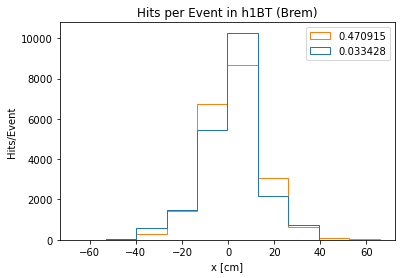

<Figure size 432x288 with 0 Axes>

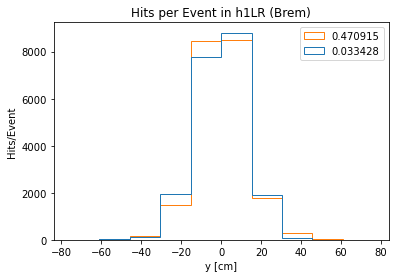

<Figure size 432x288 with 0 Axes>

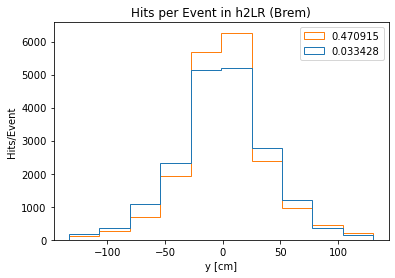

<Figure size 432x288 with 0 Axes>

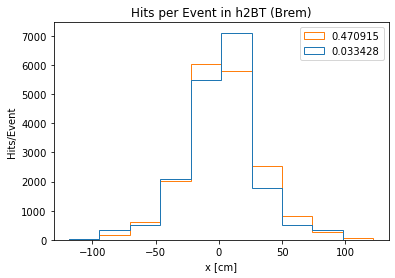

<Figure size 432x288 with 0 Axes>

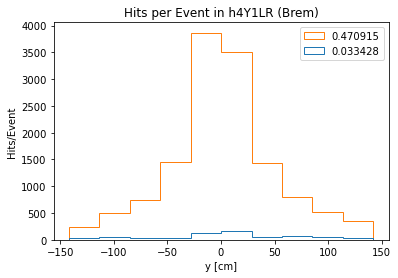

<Figure size 432x288 with 0 Axes>

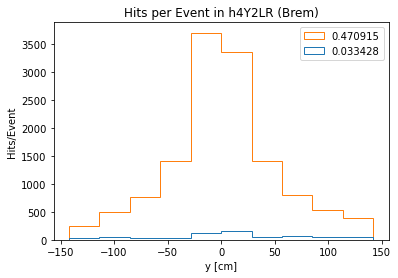

<Figure size 432x288 with 0 Axes>

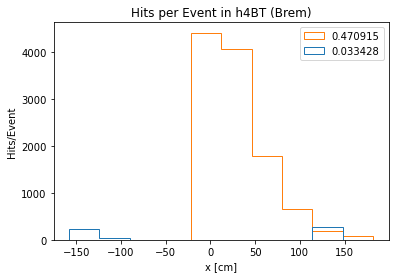

<Figure size 432x288 with 0 Axes>

In [6]:
plot1D(truth003,truth047,Brem003,Brem047)

<Figure size 432x288 with 0 Axes>

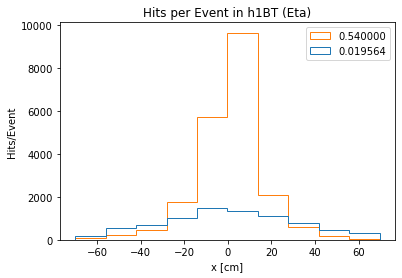

<Figure size 432x288 with 0 Axes>

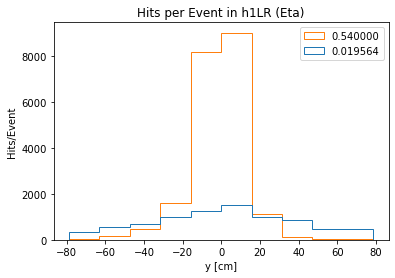

<Figure size 432x288 with 0 Axes>

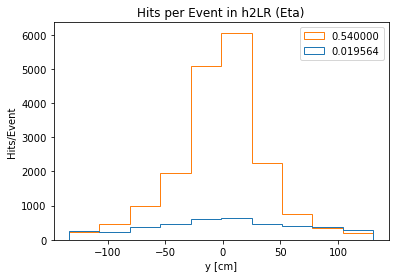

<Figure size 432x288 with 0 Axes>

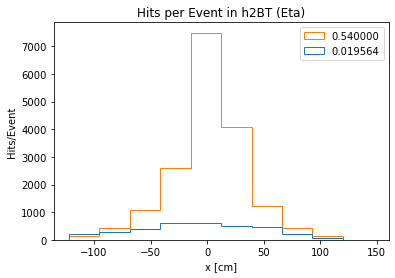

<Figure size 432x288 with 0 Axes>

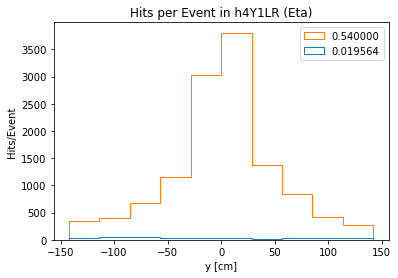

<Figure size 432x288 with 0 Axes>

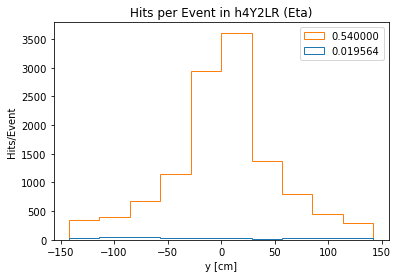

<Figure size 432x288 with 0 Axes>

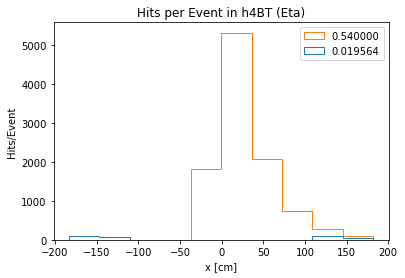

<Figure size 432x288 with 0 Axes>

In [7]:
plot1D(truth001,truth054,Eta001,Eta054)

Looking now at the 2D heatmaps:

<Figure size 432x288 with 0 Axes>

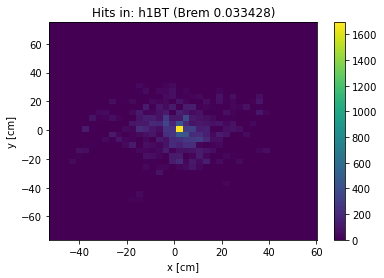

<Figure size 432x288 with 0 Axes>

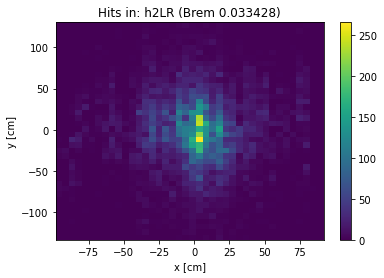

<Figure size 432x288 with 0 Axes>

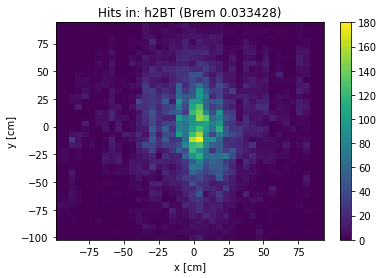

<Figure size 432x288 with 0 Axes>

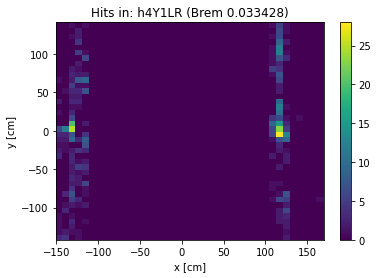

<Figure size 432x288 with 0 Axes>

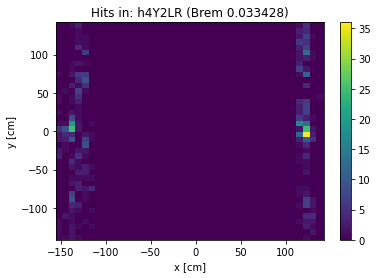

<Figure size 432x288 with 0 Axes>

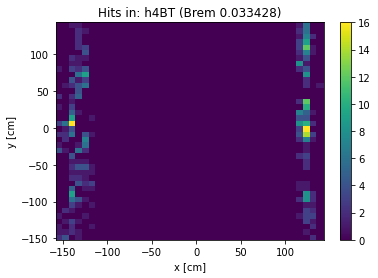

<Figure size 432x288 with 0 Axes>

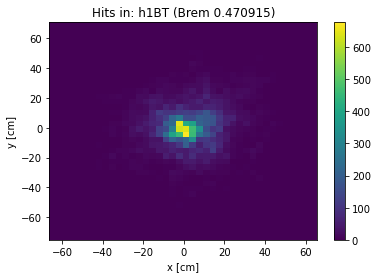

<Figure size 432x288 with 0 Axes>

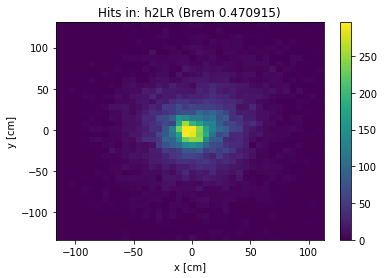

<Figure size 432x288 with 0 Axes>

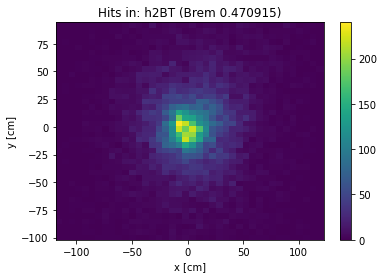

<Figure size 432x288 with 0 Axes>

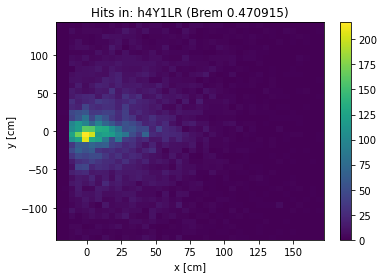

<Figure size 432x288 with 0 Axes>

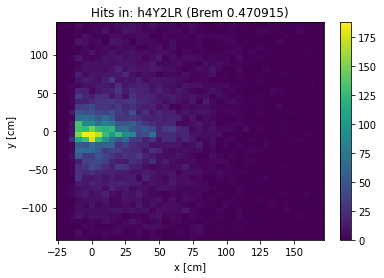

<Figure size 432x288 with 0 Axes>

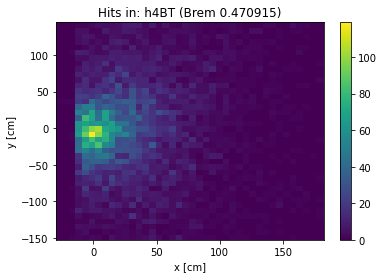

ValueError: autodetected range of [nan, nan] is not finite

<Figure size 432x288 with 0 Axes>

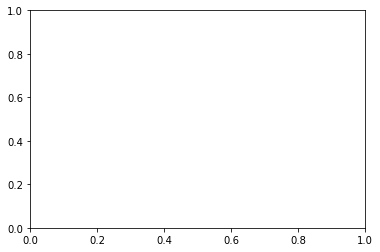

In [8]:
procs = [Brem003,Brem047,Eta001,Eta054]
for proc in procs:
    plot2D(proc)

<Figure size 432x288 with 0 Axes>

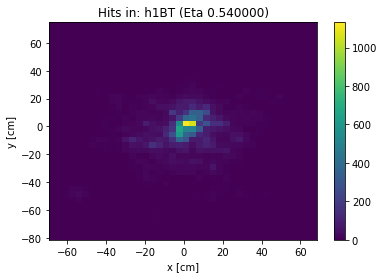

<Figure size 432x288 with 0 Axes>

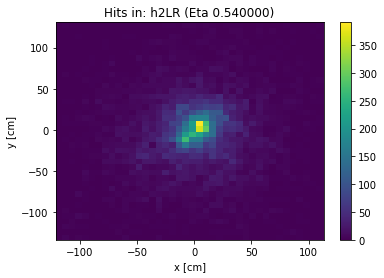

<Figure size 432x288 with 0 Axes>

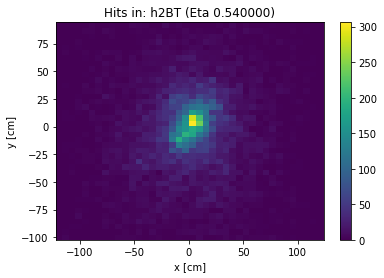

ValueError: autodetected range of [nan, nan] is not finite

<Figure size 432x288 with 0 Axes>

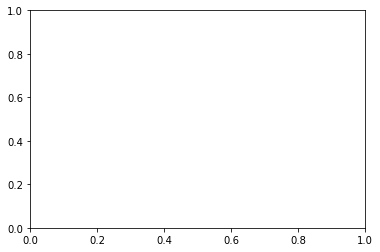

In [9]:
plot2D(Eta054)